# Text sentiment analysis with LSTMs and logistic regression
First we import basic modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import np_utils
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation ,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


# Import the data

In [2]:
data = pd.read_csv('C:\\Users\\KILDE\\Desktop\\vxk969\\dataset\\apple_dataset_mine.csv')
data.head()

,Date,Open,Close,Open-close,label,Top1,Top2,Top3,Top4,Top5,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,08-08-08,23.408571,24.221428,0.812857,1,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,11-08-08,24.295713,24.794285,0.498572,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,12-08-08,24.788572,25.247143,0.458571,1,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,13-08-08,25.425714,25.614286,0.188572,1,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,14-08-08,25.475714,25.617144,0.141430,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,...,b'Bank analyst forecast Georgian crisis 2 days...,"b""Georgia confict could set back Russia's US r...",b'War in the Caucasus is as much the product o...,"b'""Non-media"" photos of South Ossetia/Georgia ...",b'Georgian TV reporter shot by Russian sniper ...,b'Saudi Arabia: Mother moves to block child ma...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...


# Check for null values and delete them

In [3]:
data.isnull().sum()

Date          0
Open          0
Close         0
Open-close    0
label         0
Top1          0
Top2          0
Top3          0
Top4          0
Top5          0
Top6          0
Top7          0
Top8          0
Top9          0
Top10         0
Top11         0
Top12         0
Top13         0
Top14         0
Top15         0
Top16         0
Top17         0
Top18         0
Top19         0
Top20         0
Top21         0
Top22         0
Top23         1
Top24         3
Top25         3
dtype: int64

In [4]:
data = data.dropna(how='any',axis=0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 1987
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1985 non-null   object 
 1   Open        1985 non-null   float64
 2   Close       1985 non-null   float64
 3   Open-close  1985 non-null   float64
 4   label       1985 non-null   int64  
 5   Top1        1985 non-null   object 
 6   Top2        1985 non-null   object 
 7   Top3        1985 non-null   object 
 8   Top4        1985 non-null   object 
 9   Top5        1985 non-null   object 
 10  Top6        1985 non-null   object 
 11  Top7        1985 non-null   object 
 12  Top8        1985 non-null   object 
 13  Top9        1985 non-null   object 
 14  Top10       1985 non-null   object 
 15  Top11       1985 non-null   object 
 16  Top12       1985 non-null   object 
 17  Top13       1985 non-null   object 
 18  Top14       1985 non-null   object 
 19  Top15       1985 non-null  

# Split the dataset (date based split)

In [6]:
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

# Choose only the headlines columns

In [7]:
news_train = train.iloc[:,5:30]
news_train.head()

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',"b""The commander of a Navy air reconnaissance s...","b""92% of CNN readers: Russia's actions in Geor...",...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksande

In [8]:
news_train.keys()

Index(['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9',
       'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17',
       'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'],
      dtype='object')

In [9]:
type(news_train)

pandas.core.frame.DataFrame

In [10]:
news_train.columns

Index(['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9',
       'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17',
       'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'],
      dtype='object')

# All letters to lowercase, remove stopwards, Index the columns with numbers so we call loop through them easily

In [11]:
news_train = news_train.apply(lambda x: x.astype(str).str.lower())


In [12]:

stop_words= stopwords.words('english')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('not')
news_train = news_train.apply(lambda x: [item for item in x if item not in stop_words])


In [13]:
list1=[i for i in range(25)]
new_Index=[str(i) for i in list1]
news_train.columns= new_Index
# for index in new_Index:
#     news[index]=news[index].str.lower()

In [14]:
# preProcess(news)
news_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,"b""georgia 'downs two russian warplanes' as cou...",b'breaking: musharraf to be impeached.',b'russia today: columns of troops roll into so...,b'russian tanks are moving towards the capital...,"b""afghan children raped with 'impunity,' u.n. ...",b'150 russian tanks have entered south ossetia...,"b""breaking: georgia invades south ossetia, rus...","b""the 'enemy combatent' trials are nothing but...",b'georgian troops retreat from s. osettain cap...,b'did the u.s. prep georgia for war with russia?',...,b'georgia invades south ossetia - if russia ge...,b'al-qaeda faces islamist backlash',"b'condoleezza rice: ""the us would not act to p...",b'this is a busy day: the european union has ...,"b""georgia will withdraw 1,000 soldiers from ir...",b'why the pentagon thinks attacking iran is a ...,b'caucasus in crisis: georgia invades south os...,b'indian shoe manufactory - and again in a se...,b'visitors suffering from mental illnesses ban...,"b""no help for mexico's kidnapping surge"""
1,b'why wont america and nato help us? if they w...,b'bush puts foot down on georgian conflict',"b""jewish georgian minister: thanks to israeli ...",b'georgian army flees in disarray as russians ...,"b""olympic opening ceremony fireworks 'faked'""",b'what were the mossad with fraudulent new zea...,b'russia angered by israeli military sale to g...,b'an american citizen living in s.ossetia blam...,b'welcome to world war iv! now in high definit...,"b""georgia's move, a mistake of monumental prop...",...,b'israel and the us behind the georgian aggres...,"b'""do not believe tv, neither russian nor geor...",b'riots are still going on in montreal (canada...,b'china to overtake us as largest manufacturer',b'war in south ossetia [pics]',b'israeli physicians group condemns state tort...,b' russia has just beaten the united states ov...,b'perhaps *the* question about the georgia - r...,b'russia is so much better at war',"b""so this is what it's come to: trading sex fo..."
2,b'remember that adorable 9-year-old who sang a...,"b""russia 'ends georgia operation'""","b'""if we had no sexual harassment we would hav...","b""al-qa'eda is losing support in iraq because ...",b'ceasefire in georgia: putin outmaneuvers the...,b'why microsoft and intel tried to kill the xo...,b'stratfor: the russo-georgian war and the bal...,"b""i'm trying to get a sense of this whole geor...","b""the us military was surprised by the timing ...",b'u.s. beats war drum as iran dumps the dollar',...,b'u.s. troops still in georgia (did you know t...,b'why russias response to georgia was right',"b'gorbachev accuses u.s. of making a ""serious ...","b'russia, georgia, and nato: cold war two'",b'remember that adorable 62-year-old who led y...,b'war in georgia: the israeli connection',b'all signs point to the us encouraging georgi...,b'christopher king argues that the us and nato...,b'america: the new mexico?',"b""bbc news | asia-pacific | extinction 'by man..."
3,b' u.s. refuses israel weapons to attack iran:...,"b""when the president ordered to attack tskhinv...",b' israel clears troops who killed reuters cam...,b'britain\'s policy of being tough on drugs is...,b'body of 14 year old found in trunk; latest (...,b'china has moved 10 *million* quake survivors...,"b""bush announces operation get all up in russi...",b'russian forces sink georgian ships ',"b""the commander of a navy air reconnaissance s...","b""92% of cnn readers: russia's actions in geor...",...,b'elephants extinct by 2020?',b'us humanitarian missions soon in georgia - i...,"b""georgia's ddos came from us sources""","b'russian convoy heads into georgia, violating...",b'israeli defence minister: us against strike ...,b'gorbachev: we had no choice',b'witness: russian forces head towards tbilisi...,b' quarter of russians blame u.s. for conflict...,b'georgian president says us military will ta...,b'2006: nobel laureate aleksander solzhenitsyn...
4,b'all the experts admit that we should le

# Delete special characters and numbers and single letters

In [15]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]

for index in new_Index:
    for char in spec_chars:
        news_train[index]=news_train[index].str.replace(char, ' ')
        news_train[index]=news_train[index].str.split().str.join(" ")

In [16]:
numbers = ["0","1","2","3","4","5","6","7","8","9"]

for index in new_Index:
    for num in numbers:
        news_train[index]=news_train[index].str.replace(num, ' ')
        news_train[index]=news_train[index].str.split().str.join(" ")

In [17]:
for index in new_Index:
    news_train[index]=news_train[index].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
    news_train[index]=news_train[index].str.split().str.join(" ")

In [18]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

news_train = news_train.apply(lambda x: [stemmer.stem(y) for y in x])

In [19]:
news_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,georgia downs two russian warplanes as countri...,breaking musharraf to be impeach,russia today columns of troops roll into south...,russian tanks are moving towards the capital o...,afghan children raped with impunity official s...,russian tanks have entered south ossetia whils...,breaking georgia invades south ossetia russia ...,the enemy combatent trials are nothing but sha...,georgian troops retreat from osettain capital ...,did the prep georgia for war with russia,...,georgia invades south ossetia if russia gets i...,al qaeda faces islamist backlash,condoleezza rice the us would not act to preve...,this is busy day the european union has approv...,georgia will withdraw soldiers from iraq to he...,why the pentagon thinks attacking iran is bad ...,caucasus in crisis georgia invades south ossetia,indian shoe manufactory and again in series of...,visitors suffering from mental illnesses banne...,no help for mexico kidnapping surg
1,why wont america and nato help us if they wont...,bush puts foot down on georgian conflict,jewish georgian minister thanks to israeli tra...,georgian army flees in disarray as russians ad...,olympic opening ceremony fireworks fak,what were the mossad with fraudulent new zeala...,russia angered by israeli military sale to geo...,an american citizen living in ossetia blames a...,welcome to world war iv now in high definit,georgia move mistake of monumental proport,...,israel and the us behind the georgian aggress,do not believe tv neither russian nor georgian...,riots are still going on in montreal canada be...,china to overtake us as largest manufactur,war in south ossetia p,israeli physicians group condemns state tortur,russia has just beaten the united states over ...,perhaps the question about the georgia russia ...,russia is so much better at war,so this is what it come to trading sex for food
2,remember that adorable year old who sang at th...,russia ends georgia oper,if we had no sexual harassment we would have n...,al qa eda is losing support in iraq because of...,ceasefire in georgia putin outmaneuvers the west,why microsoft and intel tried to kill the xo $...,stratfor the russo georgian war and the balanc...,trying to get sense of this whole georgia russ...,the us military was surprised by the timing an...,beats war drum as iran dumps the dollar,...,troops still in georgia did you know they were...,why russias response to georgia was right,gorbachev accuses of making serious blunder in...,russia georgia and nato cold war two,remember that adorable year old who led your c...,war in georgia the israeli connect,all signs point to the us encouraging georgia ...,christopher king argues that the us and nato a...,america the new mexico,bbc news asia pacific extinction by man not clim
3,refuses israel weapons to attack iran report,when the president ordered to attack tskhinval...,israel clears troops who killed reuters cameraman,britain policy of being tough on drugs is poin...,body of year old found in trunk latest ransom ...,china has moved million quake survivors into p...,bush announces operation get all up in russia ...,russian forces sink georgian ship,the commander of navy air reconnaissance squad...,of cnn readers russia actions in georgia justifi,...,elephants extinct bi,us humanitarian missions soon in georgia if ru...,georgia ddos came from us sourc,russian convoy heads into georgia violating truc,israeli defence minister us against strike on ...,gorbachev we had no choic,witness russian forces head towards tbilisi in...,quarter of russians blame for conflict pol,georgian president says us military will take ...,nobel laureate aleksander solzhenitsyn accuses...
4,all the experts admit that we should legalise ...,war in south osetia pictures made by russian s...,swedish wrestler ara abrahamian throws away me...,russia exaggerated the death toll in south oss...,missile that killed inside pakistan may have b...,rushdie condemns random

# Check for null values again

In [20]:
news_train.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
dtype: int64

# Join all the headliens of each day to one big paragraph

In [21]:
' '.join(str(x) for x in news_train.iloc[1,0:25])

'why wont america and nato help us if they wont help us now why did we help them in iraq bush puts foot down on georgian conflict jewish georgian minister thanks to israeli training we re fending off russia georgian army flees in disarray as russians advance gori abandoned to russia without shot fir olympic opening ceremony fireworks fak what were the mossad with fraudulent new zealand passports doing in iraq russia angered by israeli military sale to georgia an american citizen living in ossetia blames and georgian leaders for the genocide of innocent peopl welcome to world war iv now in high definit georgia move mistake of monumental proport russia presses deeper into georgia says regime change is go abhinav bindra wins first ever individual olympic gold medal for india ship heads for arctic to define territori drivers in jerusalem taxi station threaten to quit rather than work for their new boss an arab the french team is stunned by phelps and the relay team israel and the us behind

# Create the trainheadlines for the previous paragraphs

In [22]:
trainheadlines=[]
for row in range(0,len(news_train.index)):
    trainheadlines.append(' '.join(str(x) for x in news_train.iloc[row,0:25]))

In [23]:
trainheadlines[1]

'why wont america and nato help us if they wont help us now why did we help them in iraq bush puts foot down on georgian conflict jewish georgian minister thanks to israeli training we re fending off russia georgian army flees in disarray as russians advance gori abandoned to russia without shot fir olympic opening ceremony fireworks fak what were the mossad with fraudulent new zealand passports doing in iraq russia angered by israeli military sale to georgia an american citizen living in ossetia blames and georgian leaders for the genocide of innocent peopl welcome to world war iv now in high definit georgia move mistake of monumental proport russia presses deeper into georgia says regime change is go abhinav bindra wins first ever individual olympic gold medal for india ship heads for arctic to define territori drivers in jerusalem taxi station threaten to quit rather than work for their new boss an arab the french team is stunned by phelps and the relay team israel and the us behind

# Clean the test data and create testheadlines with the same procedure

In [24]:
news_test = test.iloc[:,5:30]
news_test.head()

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
9,"b""British resident held in Guantanamo Bay wins...",b'Chinese may have killed 140 Tibetans this we...,b'U.S. Navy Ships Head to Georgia',b'Hacker uncovers Chinese olympic fraud',"b""If you've ever wondered what Kim Jong Il was...","b""Russia's Nuclear Threat Is More Than Words""","b'Czech President: ""I must protest aloud again...",b'50% Of All Food Produced Is Wasted Before It...,"b""China sentences Alive in Baghdad blogger, GR...","b'""Go ahead and let Georgia declare war betwee...",...,b'Russia condemns US missile deal',b'NATOs decision to freeze relations with Mosc...,"b'Sweet Sixteen or Fraudulent Fourteen, Hacke...","b'If Russias feeling churlish, they can pretty...","b'Chinese Gymnasts 14, Official Document Shows'",b'Suicide attack kills at least 50 at Pakistan...,b'The Abkhazian Parliament has approved an off...,"b'Georgia, Bulgaria and the Second Balkan War ...","b""Terrorist reveals Pak's sinister designs on ...","b""International Olympic Committee launches pro..."
10,b'Syria says its ready to put a Russian missil...,"b'""Superclass""- new book - over the past sever...",b'Georgia did not believe Russia would respond...,b'Ossetian leader admits conducting ethnic cle...,b'Report: Push for Iraq War Preceded Intellige...,"b""Russia Capitalizes on Bush's New World Disor...",b'Americans including James Powerderly arreste...,b'Prohibited Places FOIA request refused by UK...,b'An acute water shortage in the West Bank has...,b'Australian Privacy Awareness Week',...,b'The Chinese Women Gymnasts May Lose Their Go...,b' U.S.-led coalition kills 76 Afghan civilians',b'China to Overtake UK on Renewable Energy Pro...,"b""Pakistan's Ruling Party Nominates Slain Bhut...",b'Three men held in terror probe linked to thr...,b' The U.S. hands over military secrets to Mo...,b'Fire Marshal Handcuffs Woman for Swearing',b'UK economy comes to a standstill ',b'26 year old boy discovered The Meaning of Life',b'Olympics Medal time line 1896 at 2008 '
11,"b""N Korea's Kim died in 2003; replaced by look...",b'Secret prison on Diego Garcia confirmed',b'Israel claims allowing an aid ship to reach ...,b'Pedophile attempts to assault and kidnap chi...,"b'Wealthy Mexicans, terrified of soaring kidna...","b'""If the weapon states are not prepared to ri...",b'Israeli Report: Guards regularly abuse inmates',"b""Flashback: Naked, drunk, surrounded by sex t...",b'Russia to recognize Georgia rebel regions!',b'Iraqi Teenage Girl Wearing Explosives Turns ...,...,"b""Gold Farming Comparable In $$ To India's Ent...","b""SHOCK! Amsterdam's Smoking Ban Doesn't Apply...",b'Refugee camp in Darfur under direct attack',b'2008 Globally the Coldest Year of the Centur...,"b'Mosab Hassan Yousef, son of Hamas leader, be...","b'Victims Of ""Nigerian Scams"" Giving Nigeria A...",b'Russia accused of violating ceasefire deal',b'Four killed in Kashmir protests',b'When Islamic terrorist organization donates...',"b""UK child protection database 'will be used t..."
12,b'North Korea halts denuclearisation after US ...,b'60 Children Among Dead in US Airstrike in Af...,b'The Russian Parliament has voted overwhelmin...,b'Violent animal rights activists set fire to ...,"b'NBC censored that Olympic champion, Matthew ...","b'UN says ""convincing evidence"" shows US airst...",b'Italy tries to outlaw Islam',b'Mystery virus kills 160',"b'Israeli group ""Peace Now"" says settlement co...","b""Revealed: Britain's secret propaganda war ag...",...,b'Philly-area activists released by China; Jef...,"b""Vatican describes Hindu attack on Christian ...",b'Protesters tell tales of Beijing detention- ...,b'Python kills zookeeper',b'Kelly was Murdered Says UK Intelligence Insi...,"b""Fury as image of Myra Hindley appears in 'Be...",b' North Korea to suspend nuclear disablement',b'Germans suspect Bayer pesticide in beehive c...,b'Research on terrorism is invaluable - but we...,b'Top US 

In [25]:
news_test = news_test.apply(lambda x: x.astype(str).str.lower())

In [26]:
stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('not')
news_test = news_test.apply(lambda x: [item for item in x if item not in stop_words])

In [27]:
list1=[i for i in range(25)]
new_Index=[str(i) for i in list1]
news_test.columns= new_Index

In [28]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]

for index in new_Index:
    for char in spec_chars:
        news_test[index] = news_test[index].str.replace(char, ' ')
        news_test[index] = news_test[index].str.split().str.join(" ")

In [29]:
numbers = ["0","1","2","3","4","5","6","7","8","9"]

for index in new_Index:
    for num in numbers:
        news_test[index]=news_test[index].str.replace(num, ' ')
        news_test[index]=news_test[index].str.split().str.join(" ")

In [30]:
for index in new_Index:
    news_test[index]=news_test[index].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
    news_test[index]=news_test[index].str.split().str.join(" ")

In [31]:
import pandas as pd
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

news_test = news_test.apply(lambda x: [stemmer.stem(y) for y in x])

In [32]:
' '.join(str(x) for x in news_test.iloc[1,0:25])

'syria says its ready to put russian missile system on its soil as counterweight to plans to deploy missile shield in poland and the czech republ superclass new book over the past several decades global elite has emerged whose connections to each other have become more significant than their ties to their home nations and govern georgia did not believe russia would respond to its offensive in south ossetia and was completely unprepared for the counter attack the deputy defence minister has admit ossetian leader admits conducting ethnic cleans report push for iraq war preceded intelligence find russia capitalizes on bush new world disord americans including james powerderly arrested at olympics as china clamp downs on pro tibetan group prohibited places foia request refused by uk ministry of justice on the grounds of cost tim an acute water shortage in the west bank has become so severe that most families are too poor to buy wat australian privacy awareness week british government stole

In [33]:
testheadlines = []
for row in range(0,len(news_test.index)):
    testheadlines.append(' '.join(str(x) for x in news_test.iloc[row,5:30]))

In [34]:
type(testheadlines)

list

In [35]:
testheadlines[0]

'russia nuclear threat is more than word czech president must protest aloud against the incorrect interpretation of the situation in the caucasus of all food produced is wasted before it gets us china sentences alive in baghdad blogger grl james powderly amp other citizen journalists to days in jail for covering tibet protests during the olymp go ahead and let georgia declare war between nato and russia now any half wit small country leader gets to audition for the role of archduke ferdinand cafferty georgia started war with russia vid kazakhstan is considering diverting its oil exports away from the btc pipeline that runs through georgia and using russia instead the reason russia threatens sale of offensive weapons to israel enemi belfast police confiscate boardgame in terrorist crackdown world oldest man dies at the age of russia condemns us missile d natos decision to freeze relations with moscow and washingtons inept handling of pakistan are strategic foreign policy mistak sweet si

# Traditional ML models

# Logistic Regression
TfidfVectorizer :Convert a collection of raw documents to a matrix of TF-IDF features.
min_df, max_df: When building the vocabulary ignore terms that have a document frequency strictly lower and bigger than the given threshold, respectively

ngram_range:The lower and upper boundary of the range of n-values for different n-grams to be extracted. Here er chose bigrams.


In [36]:
TF_IDF_vectorizer = TfidfVectorizer( min_df=0.03, max_df=0.98, max_features = 200000, ngram_range = (2, 2))
vtrain = TF_IDF_vectorizer.fit_transform(trainheadlines)

In [37]:
model = LogisticRegression()
model = model.fit(vtrain, train["label"])

C:\Users\KILDE\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
vtest = TF_IDF_vectorizer.transform(testheadlines)
predictions = model.predict(vtest)
accuracy =accuracy_score(test['label'], predictions)

In [39]:
print('Logistic Regression accuracy: ', accuracy)

Logistic Regression accuracy:  0.524517087667162


# LSTM
We start by initiating the number of classes we have, this is a binary classification problem. Then we tokemize the words

In [40]:
numberOfClasses = 2

In [41]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(trainheadlines)

# Transforms each text in texts to a sequence of integers.
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)

In [42]:
max_len = np.max([len(sequences_train) for review in trainheadlines])
max_len

1312

In [43]:
from collections import Counter
token_counter = Counter([token for review in sequences_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
vocab_size = len(vocab_map)
print('Vocabulary Size:', vocab_size)


Vocabulary Size: 9999


In [44]:
indexOfWords = tokenizer.word_index

In [46]:
y_train = np.array(train["label"])
y_test = np.array(test["label"])

# We pad the into sequences se we all the sequences have the same length

In [47]:
X_train = sequence.pad_sequences(sequences_train, maxlen=250)
Y_train = np_utils.to_categorical(y_train,numberOfClasses)

In [48]:
X_train[0]

array([  18, 1124,   72, 6506,   11,   38,  537,    2,   60,   72,   26,
         20, 1638,  591, 5026,  124,  153,   33, 1490,  179,   15, 2496,
        205, 5027,   13,  541, 1006,  858, 3372,   44,   62,  174,  430,
          1,  807,    6,   47,   12,   45, 2944,  838,  920, 1147,    6,
         31,    2,   74,   54,   27,   11,   53, 4118,   25,   57,   76,
       3249, 6053,  984,  566, 1401,    7, 3373,    4,  177,  183,   43,
          1, 1355,  138,   45,    5,  807,   18,   17,   47,    5,    1,
       5290,  196,  785,    8, 2055,    4,    1, 1565,  111, 3500, 8551,
          5,  925, 1148, 2103,    4,    1, 2437,    4, 7074,   32,  506,
        859,    2, 1107,   46,    4,  144,  202, 4321,  430,   28,   47,
       3968,  737,  295,  807, 7073,   98, 2557,   77,   45,  452, 1125,
         26,  313, 9705,  807,    5, 7075,  538, 1566,   47,  132,  708,
        520,  761, 3374, 2944,    1,   19,  107,   29,  486,    2,  884,
         22,   57,  287,    7,   54,   57,  592,   

In [49]:
Y_train[0]

array([0., 1.], dtype=float32)

In [50]:
X_test = sequence.pad_sequences(sequences_test, maxlen=250)
Y_test = np_utils.to_categorical(y_test, numberOfClasses)

# Here is our model

In [51]:
emdedding = 100
lstm = 100

model = Sequential()
model.add(Embedding( input_dim = 10000, output_dim = emdedding,mask_zero=True))
model.add(LSTM(lstm))
model.add(Dense(numberOfClasses, activation= 'softmax'))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [52]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,080,602
Trainable params: 1,080,602
Non-trainable params: 0
_________________________________________________________________
None


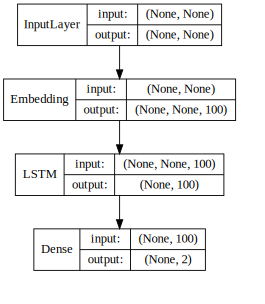

In [53]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=65, rankdir='TB').create(prog='dot', format='svg'))

# Finally, we train the model and print the accuracy

In [54]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

In [55]:
model.fit(X_train, Y_train, batch_size=32, epochs=5,validation_data=(X_test, Y_test),callbacks=[callback])

C:\Users\KILDE\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1312 samples, validate on 673 samples
Epoch 1/5
1312/1312 [==============================] - 10s 8ms/step - loss: 0.6939 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 2/5
1312/1312 [==============================] - 9s 7ms/step - loss: 0.5905 - accuracy: 0.8003 - val_loss: 0.7809 - val_accuracy: 0.5082
Epoch 3/5
1312/1312 [==============================] - 9s 7ms/step - loss: 0.2167 - accuracy: 0.9268 - val_loss: 1.0651 - val_accuracy: 0.4903
Epoch 4/5
1312/1312 [==============================] - 9s 7ms/step - loss: 0.0480 - accuracy: 0.9893 - val_loss: 1.2948 - val_accuracy: 0.5260


In [56]:
score, acc = model.evaluate(X_test, Y_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

673/673 [==============================] - 1s 2ms/step
Test score: 1.2947891055209144
Test accuracy: 0.5260029435157776


In [57]:
pred = model.predict_classes(X_test, verbose=0)
acc = accuracy_score(test['label'], pred)
print('prediction accuracy: ', acc)

prediction accuracy:  0.5260029717682021


# websites used for this project

https://keras.io/

dataset : https://www.kaggle.com/aaron7sun/stocknews